In [1]:
import pandas as pd
from collections import defaultdict
%matplotlib inline

# RDF Primer

The RDF data model represents a directed, labeled graph as a set of *triples*. A triple consists of a *subject* (node), a *predicate* (directed edge) and an *object* (node). We will interact with the graph by way of these triples

<img src="files/refresher.png">



# Analysis with Brick

One of the primary benefits of having a machine-readable representation of a building is the ability to build portable analytics. Rather than hard-coding the specific data streams and points from a building into an analytics script, we can discover that structure dynamically by querying the Brick model.

The goal of this part of the tutorial is to demonstrate how to write SPARQL queries that pull information from such graphs, and how to use these queries to write portable analytics.

To help guide the queries we want to write, we've rendered a simple visualization of how class instances are connected in our sample building Brick model. The below figure tells us:
- nodes of type `brick:VAV` have `feeds` relationships with nodes of type `brick:HVAC_Zone`
- nodes of type `brick:Room` have `isPartOf` relationships with nodes of type `brick:HVAC_Zone`

<img src="files/vavhvac.png">

Here is the full graph:

<img src="files/classgraph.png">

There are only a few types of relationships (edge labels) that Brick captures, but these are sufficient for what we need. Here's a brief recap:

- **Subcomponents**: `hasPart`/`isPartOf`. Used for mechanical composition, relating HVAC zones with physical spaces
- **Identifying flows**: `feeds`/`isFedBy`. Used for flows of water, electricity, air, etc.
- **Sensing + actuation**: `hasPoint`/`isPointOf`. Used for associating sensor, setpoints, statuses, commands, meters, etc with related equipment, locations, etc
- **Location**: `hasLocation`/`isLocationOf`. Identifies the physical location of something
- **Instantiation**: `type` (implicit in the graph above)

The way we write SPARQL queries is by considering the types of "things" we care about as well as the nature of the relationships between those things.

The first thing we do is set up our query environment. For convenience, we're using the SPARQL engine included in the RDFlib Python library. We provide a brief wrapper around that library for queries, which takes care of most of the boilerplate involved in SPARQL queries. The most important part of this boilerplate are the namespace abbreviations.

Recall that in the RDF data model, all nodes are either Literals (strings) or URIs. All URIs have a namespace: for example in the URI `https://brickschema.org/schema/1.0.1/Brick#VAV`, the namespace is `https://brickschema.org/schema/1.0.1/Brick#` and the "node" is `VAV`. For convenience, we will abbreviate the URI so we can write `brick:VAV` instead of `https://brickschema.org/schema/1.0.1/Brick#VAV`.

Here are the abbreviations we will use:

| Namespace | Usage | Abbreviation |
|-----------|-------|--------------|
| `https://brickschema.org/schema/1.0.1/Brick#` | Brick classes | `brick:` |
| `https://brickschema.org/schema/1.0.1/BrickFrame#` | Brick relationships | `bf:` |
| `http://www.w3.org/1999/02/22-rdf-syntax-ns#` | class instantiation | `rdf:` |
| `http://www.w3.org/2000/01/rdf-schema#` | subclassing | `rdfs:` |
| `http://example.com#` | Nodes in our building | `ex:` |

In [2]:
from query import BrickGraph
bldg = BrickGraph()

# SPARQL Queries

## Exploring a Brick Model

We begin by executing the 'identity' SPARQL query that lists all of the triples in our model. We have chosen the variable names `?sub` `?pred` `?obj` for clarity; the *position* of the variable within a SPARQL triple conveys its role, rather than the name. For example, because `?obj` is the third item in the SPARQL triple, we know it corresponds to a node in the graph.

In [3]:
rows = bldg.query("""select ?sub ?pred ?obj where {
?sub ?pred ?obj .
}""", fullURI=False)

# print the first 10 rows
for row in rows[:10]:
    print(row)

['brick:FCU_Supply_Air_Temperature_Cooling_Setpoint', 'rdfs:subClassOf', 'brick:Supply_Air_Temperature_Cooling_Setpoint']
['brick:Supply_Fan_Status', 'rdfs:label', rdflib.term.Literal('Discharge Fan Status', lang='en')]
['brick:Cooling_On_Off', 'rdf:type', 'owl:Class']
['brick:Damper', 'rdf:type', 'owl:Class']
['brick:FCU_Run_Time_Sensor', 'rdfs:subClassOf', 'brick:Run_Time_Sensor']
['brick:Occupied_Cooling_Max_Discharge_Air_Flow_Setpoint', 'rdfs:label', rdflib.term.Literal('Occupied Cooling Max Supply Air Flow Setpoint', lang='en')]
['brick:Solar_Panel_Solar_Azimuth_Angle_Sensor', 'rdfs:label', rdflib.term.Literal('Solar_Panel Solar Azimuth Angle Sensor', lang='en')]
['brick:Discharge_Air_Temperature_High_Limit', 'rdf:type', 'owl:Class']
['brick:Cooling_Max_Discharge_Air_Flow', 'rdf:type', 'owl:Class']
['brick:Humidifier_Panel_No_Water_Alarm', 'rdfs:subClassOf', 'brick:Humidifier_Alarm']


We can see the node/edge/node construction in the returned triples.

**Listing Instances**

Let's amend this query so it starts giving us some more useful information. To start, let's list all of the VAVs in the building. To do this, we want to find all nodes that have a `rdf:type` edge (which indicates instantiation) to the `brick:VAV` node which represents the Brick VAV class. In the corresponding triple, we will put `rdf:type` in the "predicate" slot and `brick:VAV` in the "object" slot. In the subject slot, we will place a variable that will be populated when the query executes:

```sparql
?vav rdf:type brick:VAV
```

This corresponds to finding instances of the following subgraph:

<img src="files/vavclassq.png">

In [4]:
rows = bldg.query("""select ?vav where {
?vav rdf:type brick:VAV .
}""", fullURI=False)
for row in rows:
    print('?vav =',row[0])

?vav = ex:VAV_RM-1100A
?vav = ex:VAV_RM-2150
?vav = ex:VAV_RM-1100D


**Listing Neighbors**

A natural question when interacting with a new Brick model is what kind of information is associated with a particular VAV. We can express this as a SPARQL query by seeing which triples exist that have a VAV as the subject.

```sparql
ex:VAV_RM-1100D   ?pred   ?obj 
```

This corresponds to finding instances of the following subgraph:

<img src="files/vavneighbor.png">

In [5]:
rows = bldg.query("""select ?pred ?obj where {
ex:VAV_RM-2150 ?pred ?obj .
}""", fullURI=False)
for row in rows:
    print('ex:VAV_RM-2150 has edge', row[0], 'to', row[1])

ex:VAV_RM-2150 has edge rdf:type to brick:VAV
ex:VAV_RM-2150 has edge bf:feeds to ex:RM-2150


**Listing Types**

The above queries work well if we know the exact classes instantiated in our Brick model. If we don't have this information and want to discover it, we can leverage Brick's class hierarchy.

<img src="files/tempsensorclass.png">

A common use case is finding which kinds of temperature sensors exist in the Brick model. The basic form of this uses both the `rdf:type` relationship (instantiation) and the `rdfs:subClassOf` relationship. By default, mentioning a predicate only traverses a single edge in the graph. We use SPARQL's `*` operator to match "0 or more" instances of an edge to transparently query more than one level of the hierarchy. SPARQL also provides a `+` operator to match "1 or more" edges.


This matches instances that are *immediate* subclasses of `brick:Temperature_Sensor`
```sparql
?sensor   rdf:type/rdfs:subClassOf    brick:Temperature_Sensor
```

This matches instances of `brick:Temperature_Sensor` as well as instances of *any* subclass of `brick:Temperature_Sensor`
```sparql
?sensor   rdf:type/rdfs:subClassOf*    brick:Temperature_Sensor
```

This query corresponds to the following subgraph in the case of Zone Air Temperature Sensors

<img src="files/tempsensorquery.png">

We can now run this query on our real Brick model to see what flavors of Temperature Sensor exist

In [6]:
rows = bldg.query("""select ?sensor ?class where {
?sensor rdf:type ?class .
?class rdfs:subClassOf* brick:Temperature_Sensor .
}""", fullURI=False)
for row in rows:
    print(row[0], 'is an instance of', row[1])

ex:BLDA.AH1.CHWR2-T is an instance of brick:Chilled_Water_Return_Temperature_Sensor
ex:BLDA.AH1.CHWR1-T is an instance of brick:Chilled_Water_Return_Temperature_Sensor


If we are not interested in the intermediate class name, we can combine the expression of the `rdf:type` and `rdfs:subClassOf*` predicates using the `/` SPARQL operator:

In [7]:
rows = bldg.query("""select ?sensor where {
?sensor rdf:type/rdfs:subClassOf* brick:Temperature_Sensor .
}""", fullURI=False)
for row in rows:
    print(row[0], 'is an instance of a subclass of Temperature_Sensor')

ex:BLDA.AH1.CHWR2-T is an instance of a subclass of Temperature_Sensor
ex:BLDA.AH1.CHWR1-T is an instance of a subclass of Temperature_Sensor


## Cross-Subsystem Queries

One of the main benefits of Brick is its ability to represent multiple building subsystems and query across them. We will explore these capabilities of Brick through the implementation of two analytics applications:
- Stuck Damper Detection
- Simultaneous Heating and Cooling Detection

The point of these explorations is not to implement cutting-edge fault detection/diagnosis algorithms, but rather to illustrate how Brick can make it easier to find the relevant data streams and make an implementation portable across buildings.

### Stuck Damper Detection

One method of detecting stuck dampers is to look at the difference between the supply air flow sensor and setpoint for a VAV.

- If the measured air flow is within some delta of the air flow setpoint, then the damper is fine
- Else, it might be broken

First, we write the Brick query(ies) to extract the relevant data streams: namely, the supply air flow sensor and supply air flow setpoint for each VAV in our building. In addition to the names of those points, we also extract from the Brick model some "timeseries identifier" that will point us to where we can obtain the actual data. Here, we use the `brick:hasUuid` relationship which points to an RDF literal corresponding to the name of a CSV data file.

Lets progressively build up the query. First, lets begin by identifying all the VAVs in the building:

```sparql
?vav   rdf:type    brick:VAV .
```

We will then identify the supply air flow setpoints and sensors using the `rdf:type` relationship, and because they measure an aspect of a VAV, we know they will be related to a VAV using the `isPointOf` relationship.

```sparql
?setpoint   rdf:type     brick:Supply_Air_Flow_Setpoint .
?sensor     rdf:type     brick:Supply_Air_Flow_Sensor .
?setpoint   bf:isPointOf brick:VAV .
?sensor     bf:isPointOf brick:VAV .
```

Lastly, we pull out the UUIDs for the timeseries

```sparql
?setpoint   brick:hasUuid  ?setpoint_uuid .
?sensor     brick:hasUuid  ?sensor_uuid .
```

In [8]:
rows = bldg.query("""select ?vav ?sensor ?setpoint ?sensor_uuid ?setpoint_uuid where {
?vav       rdf:type     brick:VAV .
?setpoint  rdf:type     brick:Supply_Air_Flow_Setpoint .
?sensor    rdf:type     brick:Supply_Air_Flow_Sensor .
?setpoint  bf:isPointOf ?vav .
?sensor  bf:isPointOf ?vav .
?setpoint   brick:hasUuid  ?setpoint_uuid .
?sensor     brick:hasUuid  ?sensor_uuid .
}""", fullURI=False)

# build a simple associative structure for the VAV points
vavs = {}
for row in rows:
    vavs[row[0]] = {'setpoint': row[4], 'sensor': row[3]}
print(vavs)

{'ex:VAV_RM-1100D': {'sensor': rdflib.term.Literal('37'), 'setpoint': rdflib.term.Literal('36')}, 'ex:VAV_RM-1100A': {'sensor': rdflib.term.Literal('25'), 'setpoint': rdflib.term.Literal('24')}, 'ex:VAV_RM-2150': {'sensor': rdflib.term.Literal('50'), 'setpoint': rdflib.term.Literal('49')}}


ex:VAV_RM-1100D has no faults
ex:VAV_RM-1100A has faults!!
ex:VAV_RM-2150 has faults!!


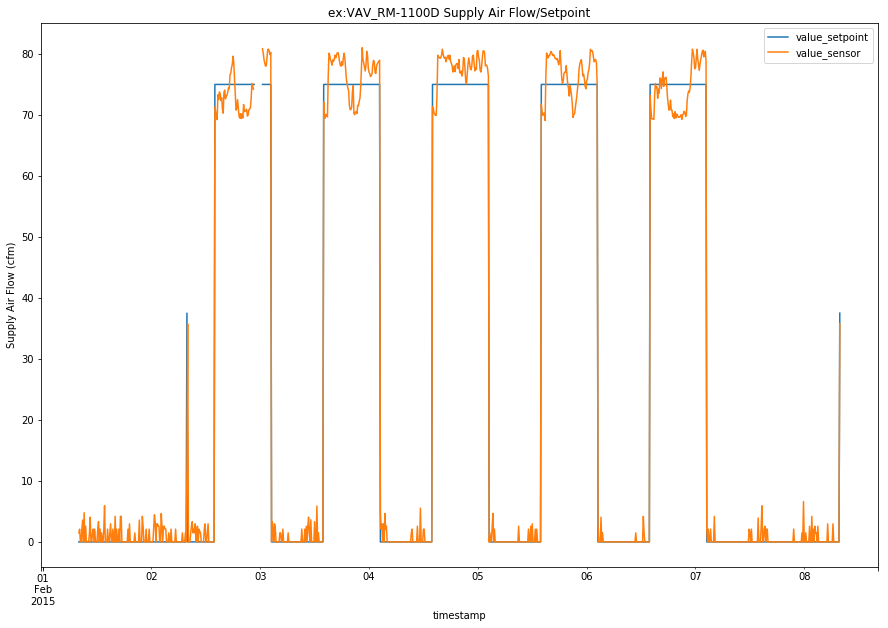

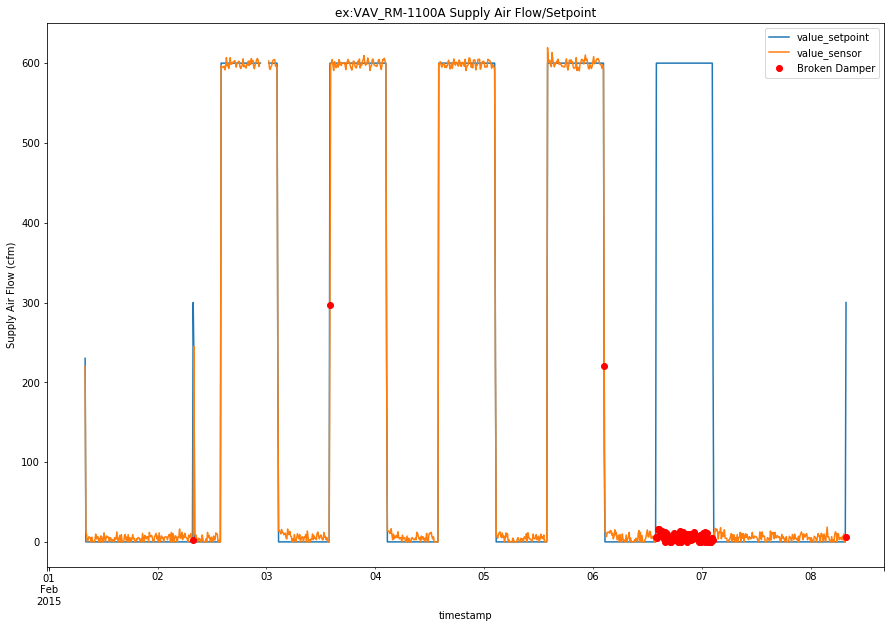

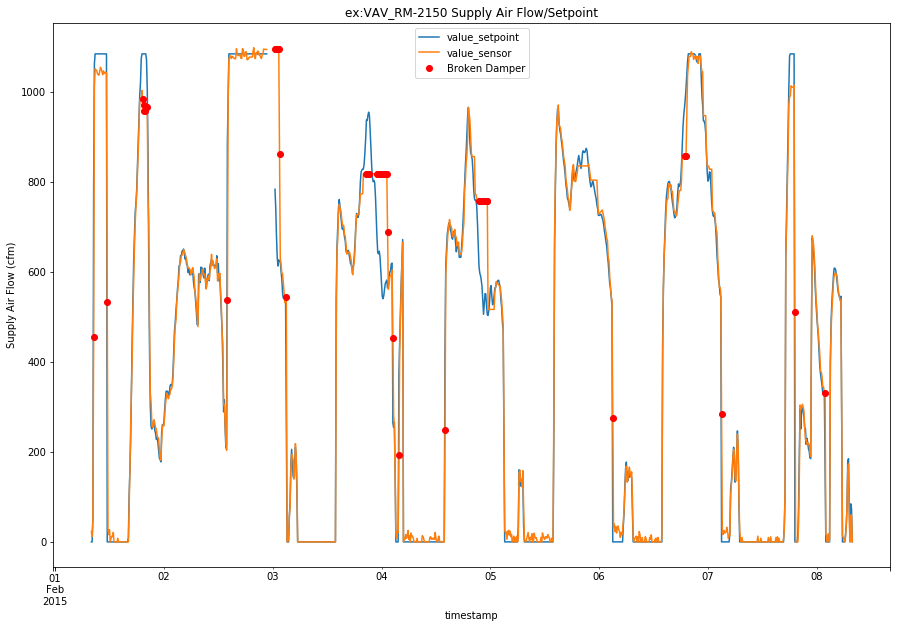

In [9]:
THRESHOLD = 100
for vavname, points in vavs.items():
    setpoint_df = pd.read_csv('data/{0}.csv'.format(points['setpoint']), usecols=['timestamp','value'])
    sensor_df = pd.read_csv('data/{0}.csv'.format(points['sensor']), usecols=['timestamp','value'])
    
    # parse timestamps
    setpoint_df = setpoint_df.set_index(pd.to_datetime(setpoint_df.pop('timestamp')))
    sensor_df = sensor_df.set_index(pd.to_datetime(sensor_df.pop('timestamp')))
    
    # resample 10-min mean
    setpoint_df = setpoint_df.resample('10T').mean()
    sensor_df = sensor_df.resample('10T').mean()
    
    # join the dataframes together so we can compare the values easier
    vav_df = setpoint_df.join(sensor_df, lsuffix='_setpoint', rsuffix='_sensor')
    ax = vav_df.plot(figsize=(15,10))
    ax.set_title('{0} Supply Air Flow/Setpoint'.format(vavname))
    ax.set_ylabel('Supply Air Flow (cfm)')
    
    # find datapoints where the difference between setpoint and sensor is greater than the threshold
    broken = vav_df[(vav_df['value_setpoint'] - vav_df['value_sensor']).abs() > THRESHOLD]
    if len(broken) > 0:
        print(vavname, 'has faults!!')
        broken.pop('value_setpoint')
        broken.columns = ['Broken Damper']
        broken.plot(style='ro',ax=ax)
    else:
        print(vavname,'has no faults')

### Simultaneous Heating and Cooling Detection

Properly identifying simultaneous heating and cooling in a building involves traversing the HVAC and spatial hierarchies of the building. We must first find rooms that are contained within more than one HVAC zone and therefore are conditioned by more than one VAV.

From this, we have a few possible avenues. First, we can compare the reheat coil percentages for the VAVs feeding a single zone. Additionally, we can look at the cooling coil percentage for the AHU upstream of each VAV combined with the supply air flow as further evidence.

To begin, we need to find rooms that are in more than one HVAC zone. We follow the same procedure for building up the query: identify the instances of the relevant classes, and then filter these by the required relationships.

The instances we are interested in for this first queries are rooms and HVAC zones:

```sparql
?room    rdf:type    brick:Room .
?zone    rdf:type    brick:HVAC_Zone .
```

We then relate rooms and HVAC zones using the proper `isPartOf` relationship:

```sparql
?room   bf:isPartOf  ?zone .
```

In [10]:
rows = bldg.query("""select ?zone ?room where {
?room rdf:type brick:Room .
?zone rdf:type brick:HVAC_Zone .
?room bf:isPartOf ?zone .
}""", fullURI=False)

# build a simple associative structure for the room -> zone mapping
rooms = defaultdict(list)
for row in rows:
     rooms[row[1]].append(row[0])

rooms_to_examine = []
for room, zonelist in rooms.items():
    if len(zonelist) > 1:
        print('Room {0} has {1} zones'.format(room, len(zonelist)))
        rooms_to_examine.append(room)

Room ex:RM-1100 has 2 zones


For each of the rooms in multiple HVAC zones, we get the reheat coil valve command for the VAVs feeding those zones. Following the rules of composition for the Brick model, we know there is:

- an `isPartOf` relationship from the room to the zone
- a `feeds` relationship from the VAV to the zone
- a `isPointOf` relationship from the reheat valve command to the VAV

We combine these into the following SPARQL triples:

```sparql
?zone    rdf:type    brick:HVAC_Zone .
?vav     rdf:type    brick:VAV .
?rhc     rdf:type    brick:Reheat_Valve_Command .

<our room>  bf:isPartOf    ?zone .
?vav        bf:feeds       ?zone .
?rhc        bf:isPointOf   ?vav .
?rhc        brick:hasUuid  ?rhc_uuid .
```

The last triple gets us the UUID for the timeseries data representing the actual reheat valve command values.

We add to our query the Supply Air Flow sensors so we can tell how much hot/cold air is being blown into a room from the different VAVs

```sparql
?saf    rdf:type      brick:Supply_Air_Flow_Sensor .
?saf    bf:isPointOf  ?vav .
?saf    brick:hasUuid ?saf_uuid .
```

[['ex:VAV_RM-1100A', rdflib.term.Literal('23'), rdflib.term.Literal('25')], ['ex:VAV_RM-1100D', rdflib.term.Literal('35'), rdflib.term.Literal('37')]]


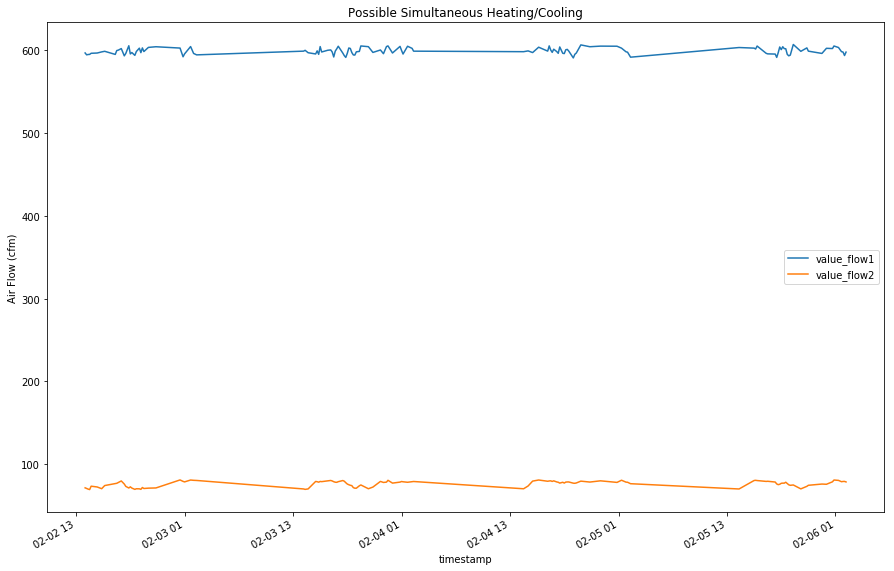

In [11]:
RHC_THRESHOLD = 50
for room in rooms_to_examine:
    rows = bldg.query("""select ?vav ?rhc_uuid ?saf_uuid where {{
    ?zone    rdf:type    brick:HVAC_Zone .
    ?vav     rdf:type    brick:VAV .
    ?rhc     rdf:type    brick:Reheat_Valve_Command .
    ?saf     rdf:type    brick:Supply_Air_Flow_Sensor .
    {0} bf:isPartOf    ?zone .
    ?vav        bf:feeds       ?zone .
    ?rhc        bf:isPointOf   ?vav .
    ?rhc        brick:hasUuid  ?rhc_uuid .
    ?saf        bf:isPointOf   ?vav .
    ?saf        brick:hasUuid  ?saf_uuid .
    }}""".format(room), fullURI=False)
    print(rows)
    rhc1 = pd.read_csv('data/{0}.csv'.format(rows[0][1]), usecols=['timestamp','value'])
    flow1 = pd.read_csv('data/{0}.csv'.format(rows[0][2]), usecols=['timestamp','value'])

    rhc2 = pd.read_csv('data/{0}.csv'.format(rows[1][1]), usecols=['timestamp','value'])
    flow2 = pd.read_csv('data/{0}.csv'.format(rows[1][2]), usecols=['timestamp','value'])

    # parse timestamps
    rhc1 = rhc1.set_index(pd.to_datetime(rhc1.pop('timestamp'))).resample('10T').mean()
    flow1 = flow1.set_index(pd.to_datetime(flow1.pop('timestamp'))).resample('10T').mean()
    rhc2 = rhc2.set_index(pd.to_datetime(rhc2.pop('timestamp'))).resample('10T').mean()
    flow2 = flow2.set_index(pd.to_datetime(flow2.pop('timestamp'))).resample('10T').mean()
    
    # join the dataframes together so we can compare the values easier
    rhc = rhc1.join(rhc2, lsuffix='_rhc1', rsuffix='_rhc2')
    flow = flow1.join(flow2, lsuffix='_flow1', rsuffix='_flow2')
    #rhc.plot(figsize=(15,10))
    #flow.plot(figsize=(15,10))
    
    # find ranges where the reheat coil commands are more than RHC_THRESHOLD away 
    # from each other and the supply air flow is non-zero for both
    diff_rhc_values = ((rhc['value_rhc1'] - rhc['value_rhc2']).abs() >= RHC_THRESHOLD)
    non_zero_saf = ((flow['value_flow1'] > 50) & (flow['value_flow2'] > 50))
    ax = flow[(diff_rhc_values & non_zero_saf)].plot(figsize=(15,10))
    ax.set_title('Possible Simultaneous Heating/Cooling')
    ax.set_ylabel('Air Flow (cfm)')

Another way of looking at the simultaneous heating/cooling problem is by comparing the heating/cooling setpoints for the two VAVs. Similar to how we ask the Brick model for the reheat coil command and supply air flow temperature sensor, we can also ask the Brick model for the heating/cooling setpoints for the zone.

The building we're working with exposes the *effective* setpoint rather than the *actual* setpoint, so we need to adjust our query from asking for instances of `Heating Temperature Setpoint` to instances of *subclasses* of `Heating Temperature Setpoint`. A sufficiently advanced application might treat effective setpoints differently, but for our basic analysis, we will make this conflation.

Below, we construct the Brick query to obtain this information, and then compute the "effective deadband", which is the actual range of temperatures allowed before one of the VAVs starts operating. As we can see from the data, the effective deadband is only about 1 degree Fahrenheit

[['ex:VAV_RM-1100A', rdflib.term.Literal('16'), rdflib.term.Literal('15')], ['ex:VAV_RM-1100D', rdflib.term.Literal('28'), rdflib.term.Literal('27')]]


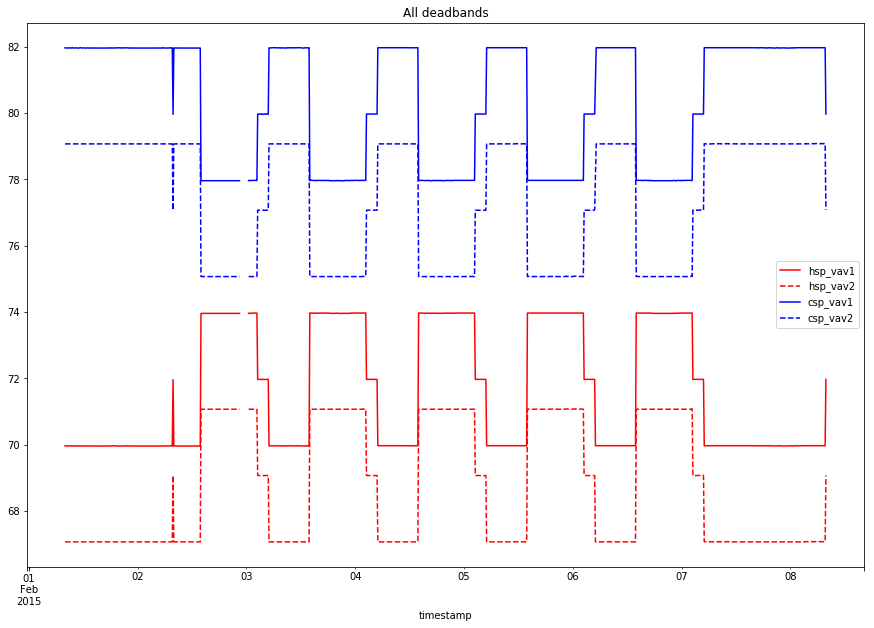

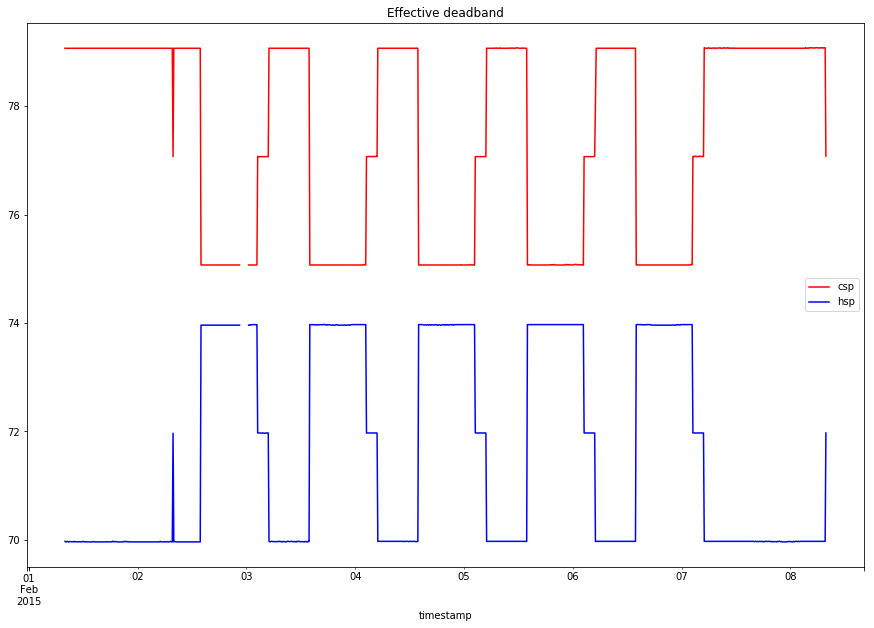

In [12]:
for room in rooms_to_examine:
    rows = bldg.query("""select ?vav ?hsp_uuid ?csp_uuid where {{
    ?zone    rdf:type    brick:HVAC_Zone .
    ?vav     rdf:type    brick:VAV .
    ?hsp     rdf:type/rdfs:subClassOf*    brick:Heating_Temperature_Setpoint .
    ?csp     rdf:type/rdfs:subClassOf*    brick:Cooling_Temperature_Setpoint .
    {0} bf:isPartOf    ?zone .
    ?vav        bf:feeds       ?zone .
    ?hsp        bf:isPointOf   ?vav .
    ?hsp        brick:hasUuid  ?hsp_uuid .
    ?csp        bf:isPointOf   ?vav .
    ?csp        brick:hasUuid  ?csp_uuid .
    }}""".format(room), fullURI=False)
    print(rows)
    vav1_hsp = pd.read_csv('data/{0}.csv'.format(rows[0][1]), usecols=['timestamp','value'])
    vav1_csp = pd.read_csv('data/{0}.csv'.format(rows[0][2]), usecols=['timestamp','value'])
    vav2_hsp = pd.read_csv('data/{0}.csv'.format(rows[1][1]), usecols=['timestamp','value'])
    vav2_csp = pd.read_csv('data/{0}.csv'.format(rows[1][2]), usecols=['timestamp','value'])

    
    # parse timestamps + resample
    vav1_hsp = vav1_hsp.set_index(pd.to_datetime(vav1_hsp.pop('timestamp'))).resample('10T').mean()
    vav1_csp = vav1_csp.set_index(pd.to_datetime(vav1_csp.pop('timestamp'))).resample('10T').mean()
    vav2_hsp = vav2_hsp.set_index(pd.to_datetime(vav2_hsp.pop('timestamp'))).resample('10T').mean()
    vav2_csp = vav2_csp.set_index(pd.to_datetime(vav2_csp.pop('timestamp'))).resample('10T').mean()
    vav1_hsp.columns=['hsp']
    vav2_hsp.columns=['hsp']
    vav1_csp.columns=['csp']
    vav2_csp.columns=['csp']
    
    # join the dataframes together so we can compare the values easier
    hsp = vav1_hsp.join(vav2_hsp, lsuffix='_vav1', rsuffix='_vav2')
    ax = hsp.plot(style=['r-', 'r--'], figsize=(15,10))
    csp = vav1_csp.join(vav2_csp, lsuffix='_vav1', rsuffix='_vav2')
    csp.plot(style=['b-','b--'], figsize=(15,10), ax=ax)
    ax.set_title('All deadbands')
    
    # compute effective deadband
    effective = pd.DataFrame({'hsp': hsp.max(axis=1), 'csp': csp.min(axis=1)})
    ax2= effective.plot(style=['r-','b-'], figsize=(15,10))
    ax2.set_title('Effective deadband')